<a href="https://colab.research.google.com/github/armandordorica/MIE1517_A1/blob/main/MIE1517_Assignment_1_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Load Iris Dataset on Google Colab

### Questions

For ## Part 1. Develop a 2-layer ANN [6pt MODEL]
Is my current code 1 or 2 layers?

* Are the analytical and numerical answers close enough?
* Why should we return `layer2` as opposed to the output after the softmax function?
* Does it make sense for the `train_loader` and `val_loader` to be the same size?

# PART A: Constructing a Neural Network [8pt]

Before we get into using PyTorch to train our classifier we will go through the process of creating our neural network from scratch. We've seen in the tutorial how to build a 1-layer network, now we'll take it one step further to build a 2-layer network. This is an important exercise that everyone should attempt at least once to understand and truly appreciate the workings of neural networks.

#### Helper Functions

To help guide the construction we will use the iris dataset that was introduced in the tutorial. Provided are some helper code to get us started:

In [5]:
# load "Iris_3class.csv" to Google Colab
from google.colab import files
uploaded = files.upload()

Saving Iris_3class.csv to Iris_3class.csv


### Helper Functions

In [7]:

def compute_metrics(true_labels, predicted_labels):
    # Compute confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)

    metrics_list = []

    # Deriving metrics for each class
    for i, species in enumerate(true_labels.unique()):
        true_positive = cm[i, i]
        false_positive = sum(cm[:, i]) - true_positive
        false_negative = sum(cm[i, :]) - true_positive
        true_negative = sum(sum(cm)) - true_positive - false_positive - false_negative

        accuracy = (true_positive + true_negative) / (true_positive + true_negative + false_positive + false_negative)
        precision = true_positive / (true_positive + false_positive)
        recall = true_positive / (true_positive + false_negative)
        f1_score = 2 * precision * recall / (precision + recall)

        metrics_list.append({
            "Class": species,
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "F1 Score": f1_score
        })

    return pd.DataFrame(metrics_list)

In [8]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix


raw_data = pd.read_csv("Iris_3class.csv", header = None)
raw_data = raw_data.values
np.random.shuffle(raw_data)

In [9]:
raw_data.shape

(150, 5)

In [10]:
columns = ['sepal length in cm', 'sepal width in cm', 'petal length in cm', 'petal width in cm', 'species']

# Convert to DataFrame
df = pd.DataFrame(raw_data, columns=columns)

# To see the first few rows of the dataframe
df.head()

,sepal length in cm,sepal width in cm,petal length in cm,petal width in cm,species
0,6.6,2.9,4.6,1.3,1.0
1,6.7,3.1,4.7,1.5,1.0
2,5.4,3.7,1.5,0.2,0.0
3,4.9,3.0,1.4,0.2,0.0
4,6.4,2.9,4.3,1.3,1.0


In [11]:
train_df = df.iloc[0:100]

X_train = df.iloc[0:100, :4]
y_train = df.iloc[0:100, 4:5].astype(int)

X_val = df.iloc[100:, :4]
y_val = df.iloc[100:, 4:5].astype(int)


In [12]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((100, 4), (100, 1), (50, 4), (50, 1))

Recall that the neural network output consists of several nodes, one for each output class. Since the labels are provided as integers we will need to convert them into one-hot vectors to match the neural network output format.

In [13]:
#Convert array to one-hot encoding
def to_one_hot(Y):
    n_col = np.amax(Y) + 1
    binarized = np.zeros((len(Y), n_col))
    for i in range(len(Y)):
        binarized[i, Y[i]] = 1.
    return binarized

In [14]:
y_train_one_hot_encoded = pd.DataFrame(to_one_hot(y_train.values))
y_train_one_hot_encoded = y_train_one_hot_encoded.astype(int)


y_val_one_hot_encoded = pd.DataFrame(to_one_hot(y_train.values))
y_val_one_hot_encoded = y_val_one_hot_encoded.astype(int)


y_train_one_hot_encoded.shape, y_val_one_hot_encoded.shape

((100, 3), (100, 3))

## Part 1. Develop a 2-layer ANN [6pt MODEL]
At its core a 2-layer neural network is just a few lines of code. Most of the complexity comes from setting up the training of the network.

Using vectorized form, set up the neural network training to use a cross-entropy loss function and determine the gradients with respect to the layer 1 and layer 2 weights.

In [4]:
import numpy as np

# define sigmoid
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# derivative of sigmoid
def sigmoid_prime(x):
    return sigmoid(x) * (1 - sigmoid(x))

# define softmax
def softmax(x):
    e = np.exp(x)
    return e / e.sum(axis=1, keepdims=True)

def ann(W, X_train, y_train):
    num_hidden = 5
    num_features = 4
    num_outputs = 3

    # Weights
    w0 = W[:20].reshape(num_features, num_hidden)
    w1 = W[20:].reshape(num_hidden, num_outputs)

    # Feed forward
    layer0 = X_train
    layer1 = sigmoid(np.dot(layer0, w0))
    layer2 = np.dot(layer1, w1)

    # softmax
    output = softmax(layer2)

    # cross-entropy loss
    m = y_train.shape[0]
    log_likelihood = -np.sum(y_train * np.log(output))
    error = log_likelihood / m

    # Back propagation using gradient descent
    # calculate gradients
    dZ2 = output - y_train
    dw1 = np.dot(layer1.T, dZ2) / m

    dZ1 = np.dot(dZ2, w1.T) * sigmoid_prime(np.dot(layer0, w0))
    dw0 = np.dot(layer0.T, dZ1) / m

    # combine gradients into one vector
    dW = np.concatenate((dw0.flatten(), dw1.flatten()))

    return (error, dW, layer2)


In [18]:
num_hidden = 5
num_features = 4
num_outputs = 3

#initialize weights
w0 = 2*np.random.random((num_features, num_hidden)) - 1
w1 = 2*np.random.random((num_hidden, num_outputs)) - 1

#combine weights into a single vector
W = np.array(list(w0.flatten()) + list(w1.flatten()))

#train network
n = 0.001
iterations = 100000
errors = []
for i in range(iterations):
  if i%10000==0:
    print(i)
  (error, dW, y_pred) = ann(W, X_train, y_train_one_hot_encoded)
  W += -dW * n
  errors.append(error)


0
10000
20000
30000
40000
50000
60000
70000
80000
90000


In [19]:
#examine predictions on training data
(_, _, y_pred) = ann(W, X_train, y_train_one_hot_encoded)
pred = np.round(y_pred, 0)
pred[:5]

array([[-1.,  2., -1.],
       [-1.,  2., -0.],
       [ 4.,  1., -4.],
       [ 4.,  1., -4.],
       [-1.,  2., -1.]])

In [20]:
train_df.head()

,sepal length in cm,sepal width in cm,petal length in cm,petal width in cm,species
0,6.6,2.9,4.6,1.3,1.0
1,6.7,3.1,4.7,1.5,1.0
2,5.4,3.7,1.5,0.2,0.0
3,4.9,3.0,1.4,0.2,0.0
4,6.4,2.9,4.3,1.3,1.0


In [21]:
train_df['y_pred'] = np.argmax(pred, axis=1)
train_df.head()

<ipython-input-21-ebaa8fe7e5db>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['y_pred'] = np.argmax(pred, axis=1)


,sepal length in cm,sepal width in cm,petal length in cm,petal width in cm,species,y_pred
0,6.6,2.9,4.6,1.3,1.0,1
1,6.7,3.1,4.7,1.5,1.0,1
2,5.4,3.7,1.5,0.2,0.0,0
3,4.9,3.0,1.4,0.2,0.0,0
4,6.4,2.9,4.3,1.3,1.0,1


### Measuring performance at predicting each of the classes

* **Iris setosa** (usually coded as 0): This is one of the species of the dataset. It's characterized by its small size compared to the other two species and its distinctively short and wide petals.
* **Iris versicolor** (usually coded as 1): This is the second species of the dataset. It's an intermediate species in terms of petal length and width, lying between the setosa and virginica species in size.
* **Iris virginica** (usually coded as 2): This is the third species of the dataset. It's characterized by its large size compared to the other two species, with long and narrow petals.


In [22]:


# Example usage:
metrics_df = compute_metrics(train_df['species'], train_df['y_pred'])
metrics_df.style.bar(subset = ['Accuracy', 'Precision', 'Recall', 'F1 Score'], align='mid', color=['red', 'lightgreen'])


,Class,Accuracy,Precision,Recall,F1 Score
0,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.000000,0.990000,1.000000,0.972222,0.985915
2,2.000000,0.990000,0.968750,1.000000,0.984127


In [23]:
# write code to numerical verify the gradients you calculated

num_hidden = 5
num_features = 4
num_outputs = 3

# initialize weights
w0 = 2*np.random.random((num_features, num_hidden)) - 1
w1 = 2*np.random.random((num_hidden, num_outputs)) - 1

# combine weights
W = np.concatenate((w0.flatten(), w1.flatten()))

# compute gradients analytically
(error, dW, y_pred) = ann(W, X_train, y_train_one_hot_encoded)

# compute gradients numerically
dW_num = np.zeros((len(W), 1))
eps = 1e-6  # Small constant

for ind in range(len(W)):
    # reset gradients
    We1 = np.array(list(w0.flatten()) + list(w1.flatten()))
    We2 = np.array(list(w0.flatten()) + list(w1.flatten()))

    # increment slightly
    We1[ind] += eps
    We2[ind] -= eps

    # compute errors
    (error_e1, _, _) = ann(We1, X_train, y_train_one_hot_encoded)
    (error_e2, _, _) = ann(We2, X_train, y_train_one_hot_encoded)

    # obtain numerical gradients
    grad_num = (error_e1 - error_e2) / (2 * eps)

    # display difference between numerical and analytic gradients
    print(round(abs(grad_num - dW[ind]), 4), grad_num, dW[ind])


0    0.1283
1    0.0693
2    0.2329
dtype: float64 0   -0.145937
1   -0.086975
2    0.215271
dtype: float64 -0.017640874814874904
0    0.0137
1    0.3995
2    0.0313
dtype: float64 0   -0.208526
1    0.177243
2   -0.190965
dtype: float64 -0.2222483908701805
0    0.0002
1    0.0090
2    0.0088
dtype: float64 0    0.009036
1   -0.000229
2    0.000012
dtype: float64 0.008819511309883059
0    0.0477
1    0.4642
2    0.0528
dtype: float64 0    0.181885
1   -0.234701
2    0.282360
dtype: float64 0.22954467518196453
0    0.0430
1    0.1551
2    0.0587
dtype: float64 0    0.128377
1   -0.069702
2    0.026705
dtype: float64 0.08537956110011968
0    0.0547
1    0.0049
2    0.1407
dtype: float64 0   -0.100135
1   -0.040562
2    0.095246
dtype: float64 -0.0454512344218
0    0.0047
1    0.2309
2    0.0555
dtype: float64 0   -0.140856
1    0.085386
2   -0.090071
dtype: float64 -0.1455403959639773
0    0.0001
1    0.0062
2    0.0061
dtype: float64 0    0.006202
1   -0.000109
2    0.000006
dtype: floa

# Part B: Cars and Trucks

In [9]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms


## Part 0. Helper Functions

We will be making use of the following helper functions. You will be asked to look
at and possibly modify some of these, but you are not expected to understand all of them.

You should look at the function names and read the docstrings. If you are curious, come back and explore the code *after* making some progress on the lab.

In [10]:
###############################################################################
# Data Loading

def get_relevant_indices(dataset, classes, target_classes):
    """ Return the indices for datapoints in the dataset that belongs to the
    desired target classes, a subset of all possible classes.

    Args:
        dataset: Dataset object
        classes: A list of strings denoting the name of each class
        target_classes: A list of strings denoting the name of desired classes
                        Should be a subset of the 'classes'
    Returns:
        indices: list of indices that have labels corresponding to one of the
                 target classes
    """
    indices = []
    for i in range(len(dataset)):
        # Check if the label is in the target classes
        label_index = dataset[i][1] # ex: 9
        label_class = classes[label_index] # ex: 'truck'
        if label_class in target_classes:
            indices.append(i)
    return indices

def get_data_loader(target_classes, batch_size):
    """ Loads images of cars and trucks, splits the data into training, validation
    and testing datasets. Returns data loaders for the three preprocessed datasets.

    Args:
        target_classes: A list of strings denoting the name of the desired
                        classes. Should be a subset of the argument 'classes'
        batch_size: A int representing the number of samples per batch

    Returns:
        train_loader: iterable training dataset organized according to batch size
        val_loader: iterable validation dataset organized according to batch size
        test_loader: iterable testing dataset organized according to batch size
        classes: A list of strings denoting the name of each class
    """

    classes = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    ########################################################################
    # The output of torchvision datasets are PILImage images of range [0, 1].
    # We transform them to Tensors of normalized range [-1, 1].
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    # Load CIFAR10 training data
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_indices = get_relevant_indices(trainset, classes, target_classes)

    # Split into train and validation
    np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
    np.random.shuffle(relevant_indices)
    split = int(len(relevant_indices) * 0.8) #split at 80%

    # split into training and validation indices
    relevant_train_indices, relevant_val_indices = relevant_indices[:split], relevant_indices[split:]
    train_sampler = SubsetRandomSampler(relevant_train_indices)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               num_workers=1, sampler=train_sampler)
    val_sampler = SubsetRandomSampler(relevant_val_indices)
    val_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              num_workers=1, sampler=val_sampler)
    # Load CIFAR10 testing data
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_test_indices = get_relevant_indices(testset, classes, target_classes)
    test_sampler = SubsetRandomSampler(relevant_test_indices)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             num_workers=1, sampler=test_sampler)
    return train_loader, val_loader, test_loader, classes

###############################################################################
# Training
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def normalize_label(labels):
    """
    Given a tensor containing 2 possible values, normalize this to 0/1

    Args:
        labels: a 1D tensor containing two possible scalar values
    Returns:
        A tensor normalize to 0/1 value
    """
    max_val = torch.max(labels)
    min_val = torch.min(labels)
    norm_labels = (labels - min_val)/(max_val - min_val)
    return norm_labels

def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        labels = normalize_label(labels)  # Convert labels to 0/1
        outputs = net(inputs)
        loss = criterion(outputs, labels.float())
        corr = (outputs > 0.0).squeeze().long() != labels
        total_err += int(corr.sum())
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

###############################################################################
# Training Curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

## Part 1. Visualizing the Data

We will make use of some of the CIFAR-10 data set, which consists of
colour images of size 32x32 pixels belonging to 10 categories. You can
find out more about the dataset at https://www.cs.toronto.edu/~kriz/cifar.html

For this assignment, we will only be using the car and truck categories.
We have included code that automatically downloads the dataset the
first time that the main script is run.

In [16]:
# This will download the CIFAR-10 dataset to a folder called "data"
# the first time you run this code.
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["car", "truck"],
    batch_size=1) # One image per batch

100%|██████████| 170498071/170498071 [00:13<00:00, 12347446.78it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### Part (i) [0.5pt EXPLORATORY]

Visualize some of the data by running the code below.
Include the visualization in your writeup.

(You don't need to submit anything else.)

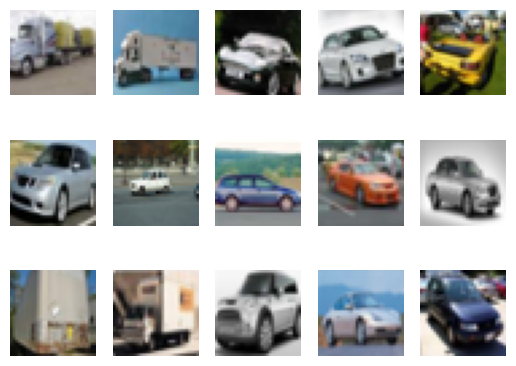

In [24]:
import matplotlib.pyplot as plt

k = 0
for images, labels in train_loader:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1,2,0])
    # normalize pixel intensity values to [0, 1]
    img = img / 2 + 0.5
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(img)

    k += 1
    if k > 14:
        break

### Part (ii) [1pt EXPLORATORY]

* How many training examples do we have for the combined `car` and `truck` classes?
* What about validation examples?

In [25]:
train_loader

In [26]:
total_training_examples = len(train_loader.dataset)
print("Total training examples for car and truck:", total_training_examples)


Total training examples for car and truck: 50000


In [27]:
total_validation_examples = len(val_loader.dataset)
print("Total validation examples for car and truck:", total_validation_examples)


Total validation examples for car and truck: 50000


## Part 2. Training

We define two neural networks, a `LargeNet` and `SmallNet`.
We'll be training the networks in this section.

You won't understand fully what these networks are doing until
the next few classes, and that's okay. For this assignment, please
focus on learning how to train networks, and how hyperparameters affect
training.

In [21]:
class LargeNet(nn.Module):
    def __init__(self):
        super(LargeNet, self).__init__()
        self.name = "large"
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)
        self.fc1 = nn.Linear(10 * 5 * 5, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [22]:
class SmallNet(nn.Module):
    def __init__(self):
        super(SmallNet, self).__init__()
        self.name = "small"
        self.conv = nn.Conv2d(3, 5, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(5 * 7 * 7, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv(x)))
        x = self.pool(x)
        x = x.view(-1, 5 * 7 * 7)
        x = self.fc(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [23]:
small_net = SmallNet()
large_net = LargeNet()

### Part (i) [1pt EXPLORATORY]

The methods `small_net.parameters()` and `large_net.parameters()`
produces an iterator of all the trainable parameters of the network.
These parameters are torch tensors containing many scalar values.

We haven't learned how how the parameters in these high-dimensional
tensors will be used, but we should be able to count the number
of parameters. Measuring the number of parameters in a network is
one way of measuring the "size" of a network.

What is the total number of parameters in `small_net` and in
`large_net`? (Hint: how many numbers are in each tensor?)


**Given the `SmallNet`**
1. For the convolution layer (`self.conv`):
    - Weights: 3 (input channels) x 5 (output channels) x 3 (kernel height) x 3 (kernel width) = 135
    - Bias: 5 (for each output channel) = 5
    Total = 140

2. For the fully connected layer (`self.fc`):
    - Weights: 5 x 7 x 7 (input features) x 1 (output features) = 245
    - Bias: 1 (for the output feature) = 1
    Total = 246

Summing these together: 140 (from the convolution layer) + 246 (from the fully connected layer) = 386 parameters in total.

So, the `SmallNet` model has 386 parameters in total.

In [34]:
for param in small_net.parameters():
    print(param.shape)

torch.Size([5, 3, 3, 3])
torch.Size([5])
torch.Size([1, 245])
torch.Size([1])


In [35]:
small_net.parameters()

<generator object Module.parameters at 0x7f34925a49e0>

In [36]:
total_params_small_net = sum(p.numel() for p in small_net.parameters() if p.requires_grad)
total_params_small_net

386

In [37]:
sum(p.numel() for p in small_net.parameters())


386

For the `LargeNet`:

1. **First Convolution Layer (`self.conv1`)**:
    - Weights: \(3 x 5 x 5 x 5\) (input channels x output channels x kernel height x kernel width)
    - Bias: \(5\) (one for each output channel)
    Hence, total parameters for `self.conv1` = \(3 x 5 x 5 x 5 + 5 = 380\)

2. **Second Convolution Layer (`self.conv2`)**:
    - Weights: \(5 x 10 x 5 x 5\)
    - Bias: \(10\)
    Hence, total parameters for `self.conv2` = \(5 x 10 x 5 x 5 + 10 = 1,260\)

3. **First Linear Layer (`self.fc1`)**:
    - Weights: \(10 x 5 x 5 x 32\)
    - Bias: \(32\)
    Hence, total parameters for `self.fc1` = \(10 x 5 x 5 x 32 + 32 = 8,032\)

4. **Second Linear Layer (`self.fc2`)**:
    - Weights: \(32 x 1\)
    - Bias: \(1\)
    Hence, total parameters for `self.fc2` = \(32 x 1 + 1 = 33\)

Pooling layers don't have learnable parameters.

The total number of parameters in `LargeNet` = \(380 + 1,260 + 8,032 + 33 = 9,705\).

So, the `LargeNet` model has 9,705 parameters in total.

In [38]:
for param in large_net.parameters():
    print(param.shape)

torch.Size([5, 3, 5, 5])
torch.Size([5])
torch.Size([10, 5, 5, 5])
torch.Size([10])
torch.Size([32, 250])
torch.Size([32])
torch.Size([1, 32])
torch.Size([1])


In [39]:
sum(p.numel() for p in large_net.parameters())

9705

### The function train_net

The function `train_net` below takes an untrained neural network (like `small_net` and `large_net`) and
several other parameters. You should be able to understand how this function works.
The figure below shows the high level training loop for a machine learning model:

![alt text](https://github.com/UTNeural/Lab2/blob/master/Diagram.png?raw=true)

In [34]:
def train_net(net, batch_size=64, learning_rate=0.01, num_epochs=30):
    ########################################################################
    # Train a classifier on cars vs trucks
    target_classes = ["car", "truck"]
    ########################################################################
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    ########################################################################
    # Obtain the PyTorch data loader objects to load batches of the datasets
    train_loader, val_loader, test_loader, classes = get_data_loader(
            target_classes, batch_size)
    ########################################################################
    # Define the Loss function and optimizer
    # The loss function will be Binary Cross Entropy (BCE). In this case we
    # will use the BCEWithLogitsLoss which takes unnormalized output from
    # the neural network and scalar label.
    # Optimizer will be SGD with Momentum.
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    ########################################################################
    # Set up some numpy arrays to store the training/test loss/erruracy
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for i, data in enumerate(train_loader, 0):
            # Get the inputs
            inputs, labels = data
            labels = normalize_label(labels) # Convert labels to 0/1
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            # Calculate the statistics
            corr = (outputs > 0.0).squeeze().long() != labels
            total_train_err += int(corr.sum())
            total_train_loss += loss.item()
            total_epoch += len(labels)
        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)
        print(("Epoch {}: Train err: {}, Train loss: {} |"+
               "Validation err: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch]))
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        print("Model Path")
        print(model_path)
        torch.save(net.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    # print("Saving files like {}_train_err.csv".format(model_path))
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

### Part (ii) [0.5pt EXPLORATORY] - default params of network

The parameters to the function `train_net` are hyperparameters of our neural network.
We made these hyperparameters easy to modify so that we can tune them later on.

What are the default values of the parameters `batch_size`, `learning_rate`,
and `num_epochs`?

 `batch_size=64`, `learning_rate=0.01`, `num_epochs=30`

### Part (iii) [0.5pt EXPLORATORY] - files written to disk
What files are written to disk when we call `train_net` with `small_net`, and train for 5 epochs? Provide a list
of all the files written to disk, and what information the files contain.

There are two main sections where files are written to the disk.


1. The first one is when this happens:

```# Save the current model (checkpoint) to a file
model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
torch.save(net.state_dict(), model_path)
```


The `model_path` is loaded from the `get_model_name` function. Every time the network gets trained (every epoch) a new version of the model will be saved.

2. The second time is when the CSV files are created after training is finished. Four CSV files are saved, which contain the training error, training loss, validation error, and validation loss for each epoch, respectively.


```python
np.savetxt("{}_train_err.csv".format(model_path), train_err)
np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
np.savetxt("{}_val_err.csv".format(model_path), val_err)
np.savetxt("{}_val_loss.csv".format(model_path), val_loss)
```

### Part (iv) [0.5pt EXPLORATORY] - train small and large net
Train both `small_net` and `large_net` using the function `train_net` and its default parameters.
The function will write many files to disk, including a model checkpoint (saved values of model weights)
at the end of each epoch.

If you are using Google Colab, you will need to mount Google Drive
so that the files generated by `train_net` gets saved. We will be using
these files in the parts that follow.
(See the Google Colab tutorial for more information about this.)

Report the total time elapsed when training each network. Which network took longer to train?
Why?

In [38]:
from google.colab import drive
drive.mount('/content/drive')
folder_path = '/content/drive/MyDrive/u of t/PhD/2023/MIE 1517 - Deep Learning/Assignments/A1'


Mounted at /content/drive


Testing a txt file to save to that Google Drive folder

In [42]:
import os
with open(os.path.join(folder_path, 'myfile.txt'), 'w') as f:
    f.write('Hello, Google Drive!')


In [40]:
import os
folder_path = '/content/drive/MyDrive/u of t/PhD/2023/MIE 1517 - Deep Learning/Assignments/A1'
os.chdir(folder_path)

In [43]:
train_net(small_net, batch_size=64, learning_rate=0.01, num_epochs=30)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.366625, Train loss: 0.6387369413375854 |Validation err: 0.3475, Validation loss: 0.6308059003204107
Model Path
model_small_bs64_lr0.01_epoch0
Epoch 2: Train err: 0.311875, Train loss: 0.5926364569664001 |Validation err: 0.3085, Validation loss: 0.5754484478384256
Model Path
model_small_bs64_lr0.01_epoch1
Epoch 3: Train err: 0.273625, Train loss: 0.5480667209625244 |Validation err: 0.254, Validation loss: 0.5218028360977769
Model Path
model_small_bs64_lr0.01_epoch2
Epoch 4: Train err: 0.2495, Train loss: 0.5092371439933777 |Validation err: 0.2235, Validation loss: 0.4745364971458912
Model Path
model_small_bs64_lr0.01_epoch3
Epoch 5: Train err: 0.20875, Train loss: 0.45691802167892454 |Validation err: 0.203, Validation loss: 0.43778558634221554
Model Path
model_small_bs64_lr0.01_epoch4
Epoch 6: Train err: 0.19575, Train loss: 0.44202469754219054 |Validation err: 0.229, Validation loss: 0.464

In [44]:
train_net(large_net, batch_size=64, learning_rate=0.01, num_epochs=30)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.455625, Train loss: 0.6893636994361877 |Validation err: 0.3725, Validation loss: 0.6715354453772306
Model Path
model_large_bs64_lr0.01_epoch0
Epoch 2: Train err: 0.35675, Train loss: 0.6333531522750855 |Validation err: 0.3605, Validation loss: 0.6327072102576494
Model Path
model_large_bs64_lr0.01_epoch1
Epoch 3: Train err: 0.3175, Train loss: 0.5890470750331879 |Validation err: 0.2785, Validation loss: 0.5528772128745914
Model Path
model_large_bs64_lr0.01_epoch2
Epoch 4: Train err: 0.242125, Train loss: 0.5013410527706146 |Validation err: 0.2225, Validation loss: 0.46245077066123486
Model Path
model_large_bs64_lr0.01_epoch3
Epoch 5: Train err: 0.194875, Train loss: 0.43517296290397645 |Validation err: 0.1905, Validation loss: 0.4207524098455906
Model Path
model_large_bs64_lr0.01_epoch4
Epoch 6: Train err: 0.178, Train loss: 0.4047458927631378 |Validation err: 0.184, Validation loss: 0.4125

The `large_net` has more layers and more units than the `small_net` so,  everything else being constant, the `large_net` should take longer to train as it has more parameters to be updated and requires more computation for each iteration, so it generally requires longer to train.

### Part (v) [0.5pt EXPLORATORY] - plot training curve function
Use the function `plot_training_curve` to display the trajectory of the
training/validation error and the training/validation loss.
You will need to use the function `get_model_name` to generate the
argument to the `plot_training_curve` function.

Do this for both the small network and the large network. Include both plots
in your writeup.

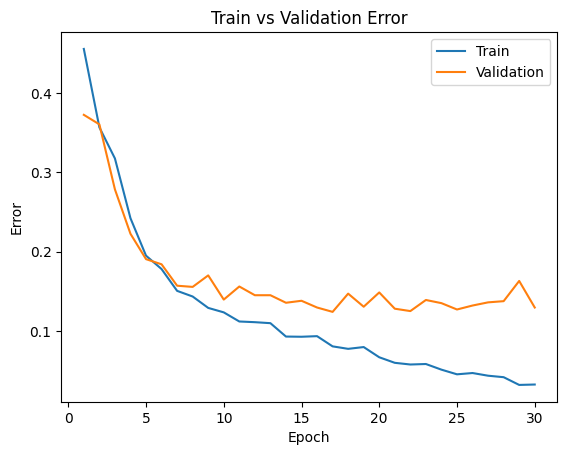

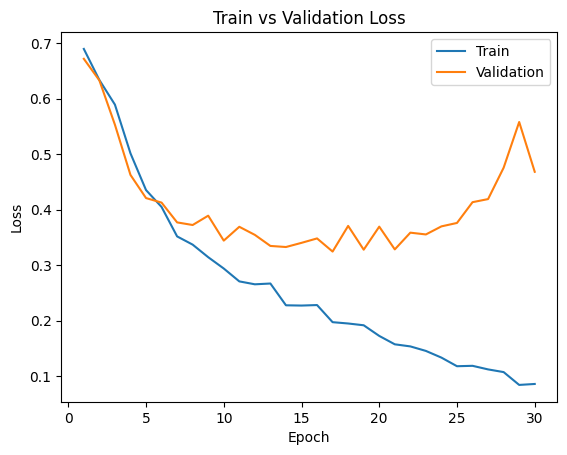

In [45]:
plot_training_curve('model_large_bs64_lr0.01_epoch29')

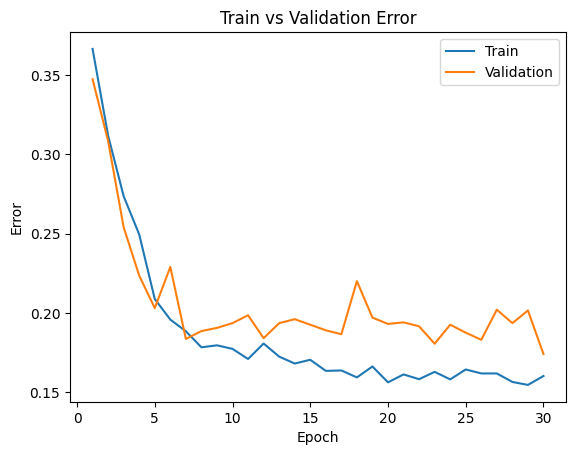

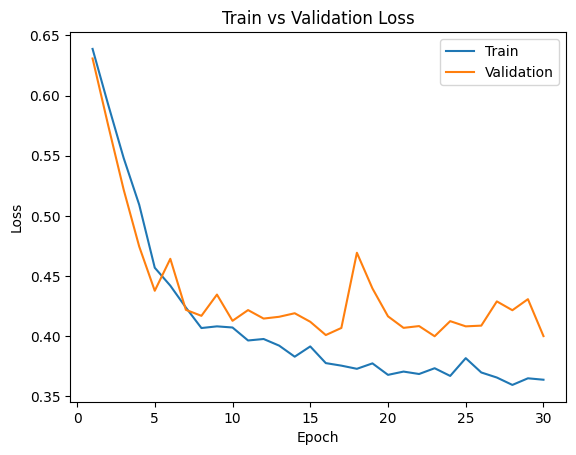

In [46]:
plot_training_curve('model_small_bs64_lr0.01_epoch29')

In [47]:
get_model_name(small_net.name, 64, 0.01, 30)

'model_small_bs64_lr0.01_epoch30'

### Part (vi) [0.5pt EXPLORATORY]
Describe what you notice about the training curve.
How do the curves differ for `small_net` and `large_net`?
Identify any occurences of underfitting and overfitting.

**Small net** seems to be fine, slightly overfitted if anything. However, the **Large net** is clearly overfitting as we see that the loss function increases for the validation set at some epoch even though the training loss keeps decreasing.

## Part 3. Optimization Parameters

For this section, we will work with `large_net` only.

### Part (i) [0.5pt EXPLORATORY] - training time vs lower learning rate
Train `large_net` with all default parameters, except set `learning_rate=0.001`.
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *lowering* the learning rate.

### Note: When we re-construct the model, we start the training with *random weights*. If we omit this code, the values of the weights will still be the previously trained values.


In [69]:
large_net = LargeNet()

In [70]:
large_net

LargeNet(
  (conv1): Conv2d(3, 5, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(5, 10, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=250, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=1, bias=True)
)

In [74]:
train_net(large_net, batch_size=64, learning_rate=0.001, num_epochs=30)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.16025, Train loss: 0.37715176701545716 |Validation err: 0.163, Validation loss: 0.3878856282681227
Model Path
model_large_bs64_lr0.001_epoch0
Epoch 2: Train err: 0.15875, Train loss: 0.37173011648654936 |Validation err: 0.173, Validation loss: 0.38921166118234396
Model Path
model_large_bs64_lr0.001_epoch1
Epoch 3: Train err: 0.159125, Train loss: 0.36735709047317505 |Validation err: 0.167, Validation loss: 0.3890552558004856
Model Path
model_large_bs64_lr0.001_epoch2
Epoch 4: Train err: 0.15375, Train loss: 0.3615174959897995 |Validation err: 0.1595, Validation loss: 0.36902537988498807
Model Path
model_large_bs64_lr0.001_epoch3
Epoch 5: Train err: 0.153875, Train loss: 0.3552902798652649 |Validation err: 0.1545, Validation loss: 0.3731292216107249
Model Path
model_large_bs64_lr0.001_epoch4
Epoch 6: Train err: 0.151, Train loss: 0.352788933634758 |Validation err: 0.15, Validation loss: 0.3

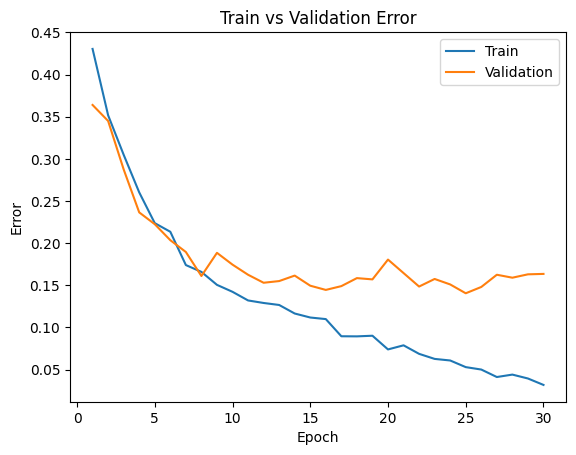

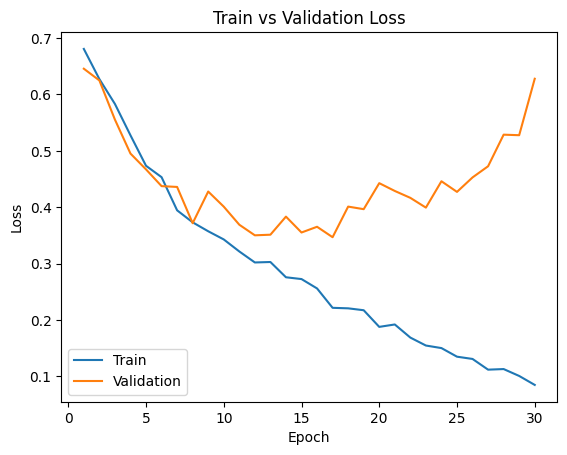

In [76]:
plot_training_curve('model_large_bs64_lr0.01_epoch29')

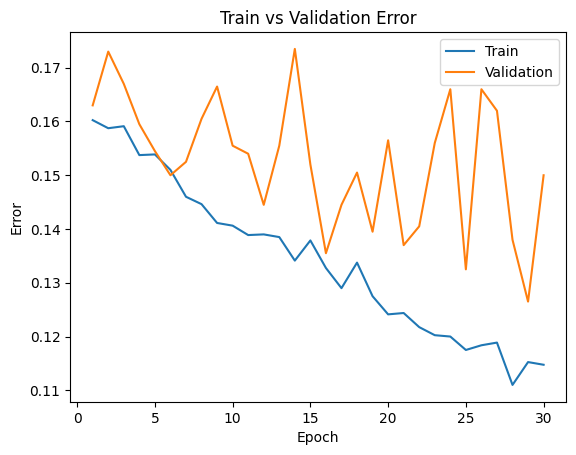

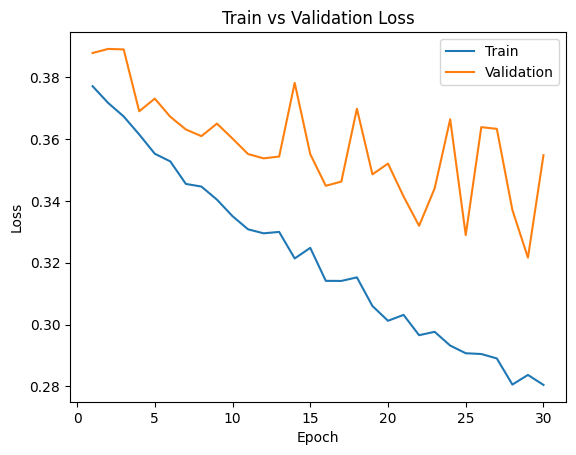

In [75]:
plot_training_curve('model_large_bs64_lr0.001_epoch29')

If we look at the y axes of both loss and error, we see that `0.001` is more optimal than `0.01` as both the error and the loss are lower. In addition, the training and validation sets are less away from each other. A lower learning rate leads to a slower but surer convergence.

Not that the **time taken per epoch when training a neural network is primarily a function of factors such as the number of operations performed, the batch size, the architecture of the network, data loading times, etc. The learning rate itself doesn't directly affect the computational operations required in an epoch. Therefore, we wouldn't expect a change in learning rate to directly affect the time taken for each epoch.**

However, there might be some indirect effects to consider:

* Convergence Behavior: With a larger learning rate, the model may oscillate more and take longer to converge. However, since we've fixed the number of epochs to 30 in both cases, this wouldn't affect the training time in this specific example.
* Numerical Precision and Stability: Extremely small or large learning rates might cause numerical issues (like vanishing or exploding gradients), which could, in theory, slightly affect computation times. But **the difference between 0.01 and 0.001 isn't drastic enough to expect this to be a major concern.**
* Other factors like random initializations, slight variations in data loading or processing times, other processes running on the machine, etc., can introduce variations in training time.

In your case, the difference in elapsed times is relatively small (136.28s for 0.01 vs  135.44 seconds and 0.001). This difference is likely due to the aforementioned factors, including small random variations. It's not due to the change in learning rate itself.

If one were to run the training multiple times, one might find that the times vary slightly with each run, even with the same parameters. It's essential to ensure that other conditions (like system load, initializations, etc.) are consistent if we're trying to perform precise benchmarks or comparisons.

### Part (ii) [0.5pt EXPLORATORY] - effect of increasing learning rate
Train `large_net` with all default parameters, except set `learning_rate=0.1`.
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the learning rate.

> Increasing the learning rate speeds up the initial learning but can lead to instability, potential divergence, and poor generalization on unseen data.

> **Convergence Speed:** A higher learning rate (like 0.1) leads to a faster initial decrease in error compared to the lower rates. However, it's important to note that faster isn't always better. The rapid changes can lead to overshooting the optimal point.

> **Stability:**
With a high learning rate (0.1), the training process becomes less stable. This is evident from the oscillations in error and, by the end of 30 epochs, a notable increase in error, indicating divergence.
A medium learning rate (0.01) shows more stable behavior than the highest rate and manages to reduce error consistently.
The lowest learning rate (0.001) is the most stable, with a slow and steady reduction in error.

> **Overfitting:**
A higher learning rate, like 0.1 in this context, doesn't show a clear sign of overfitting, but that's because it diverges before it even has the chance to overfit.
A medium rate (0.01) begins to show signs of overfitting in the later epochs as the training error continues to decrease while the validation error starts to rise.
The lowest rate (0.001) doesn't show significant signs of overfitting within the 30 epochs, but the model is learning very slowly.

> **Generalization on Validation Data:**
A high learning rate (0.1) performs poorly on the validation set after the initial few epochs, which suggests that the model isn't generalizing well due to the instability introduced by the high rate.
Medium (0.01) and low (0.001) learning rates perform better in terms of generalization, with the medium rate being more effective within the 30 epochs.
In summary, based on this context:


Increasing the learning rate speeds up the initial learning but can lead to instability, potential divergence, and poor generalization on unseen data.
While a higher learning rate can achieve faster convergence, it comes with the risk of overshooting the optimal solution and can even cause divergence in the worst-case scenario.

Finding the right learning rate is a balancing act between speeding up convergence and ensuring stability and generalization. Too high can be unstable, while too low might be too conservative and slow.





In [77]:
large_net = LargeNet()
train_net(large_net, batch_size=64, learning_rate=0.1, num_epochs=30)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.3435, Train loss: 0.6152465670108795 |Validation err: 0.2655, Validation loss: 0.5401884317398071
Model Path
model_large_bs64_lr0.1_epoch0
Epoch 2: Train err: 0.26275, Train loss: 0.5457514839172364 |Validation err: 0.2255, Validation loss: 0.47185863088816404
Model Path
model_large_bs64_lr0.1_epoch1
Epoch 3: Train err: 0.205125, Train loss: 0.4577759726047516 |Validation err: 0.196, Validation loss: 0.42472241446375847
Model Path
model_large_bs64_lr0.1_epoch2
Epoch 4: Train err: 0.18375, Train loss: 0.42987853920459745 |Validation err: 0.193, Validation loss: 0.4498207103461027
Model Path
model_large_bs64_lr0.1_epoch3
Epoch 5: Train err: 0.182875, Train loss: 0.4176621789932251 |Validation err: 0.1765, Validation loss: 0.3949774377979338
Model Path
model_large_bs64_lr0.1_epoch4
Epoch 6: Train err: 0.1775, Train loss: 0.407295166015625 |Validation err: 0.218, Validation loss: 0.47349493484

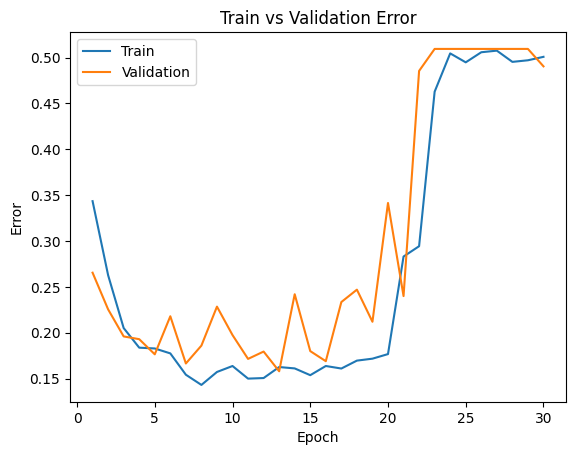

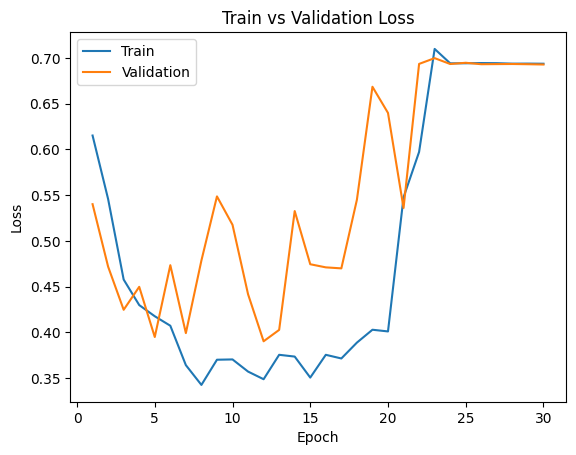

In [78]:
plot_training_curve('model_large_bs64_lr0.1_epoch29')

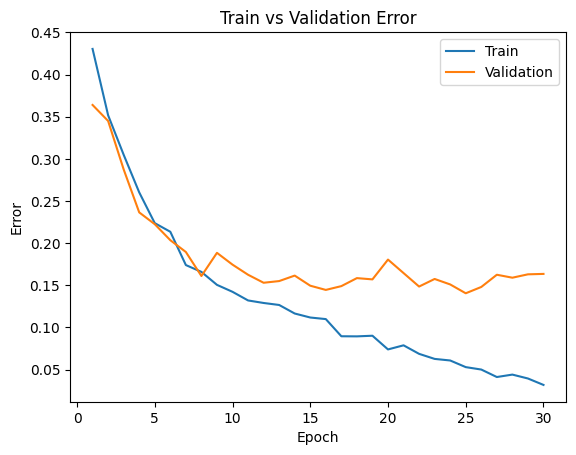

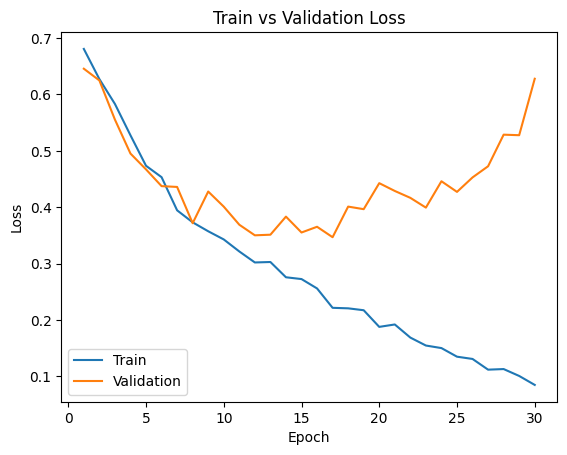

In [80]:
plot_training_curve('model_large_bs64_lr0.01_epoch29')

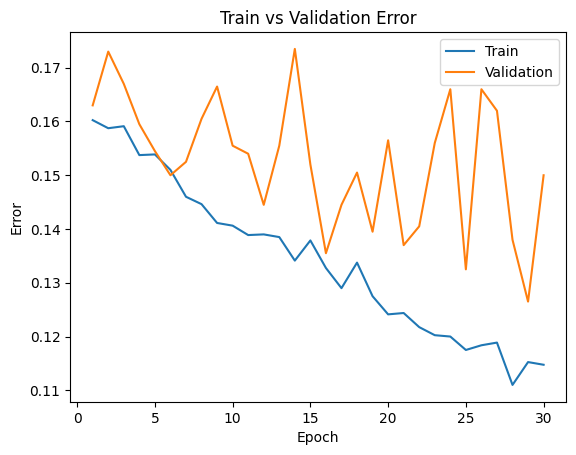

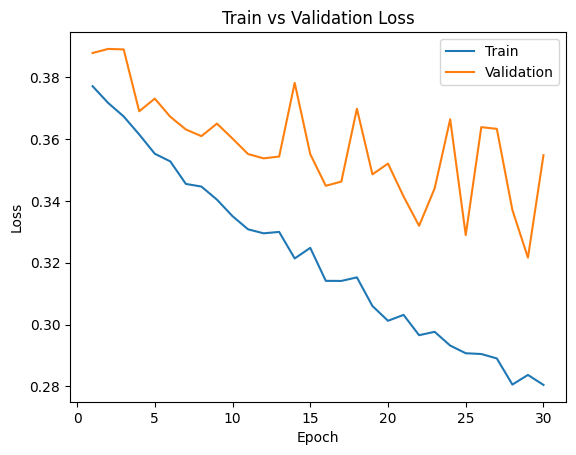

In [79]:
plot_training_curve('model_large_bs64_lr0.001_epoch29')

FileNotFoundError: ignored

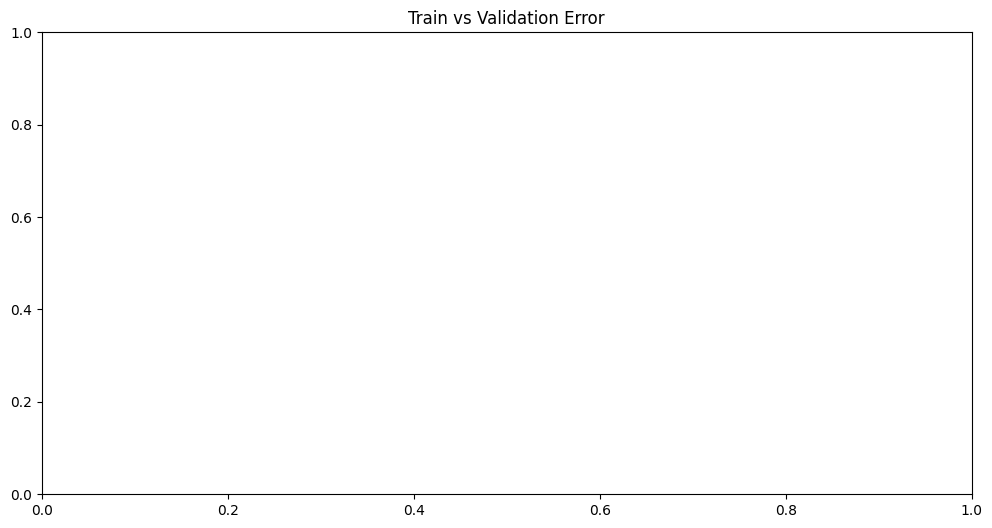

In [37]:
import numpy as np
import matplotlib.pyplot as plt

def plot_multiple_training_curves(paths, labels):
    """
    Plots the training curve for multiple model runs, given the csv files
    containing the train/validation error/loss.

    Args:
        paths: List of base paths of the csv files produced during training
        labels: List of labels for each path for legend
    """

    plt.figure(figsize=(12, 6))
    plt.title("Train vs Validation Error")

    for path, label in zip(paths, labels):
        train_err = np.loadtxt("{}_train_err.csv".format(path))
        val_err = np.loadtxt("{}_val_err.csv".format(path))

        # Print the vectors
        print(f"Train Error for {label}: {train_err}")
        print(f"Validation Error for {label}: {val_err}")

        n = len(train_err)  # number of epochs
        plt.plot(range(1, n+1), train_err, label="Train " + label)
        plt.plot(range(1, n+1), val_err, linestyle='--', label="Validation " + label)

    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.title("Train vs Validation Loss")

    for path, label in zip(paths, labels):
        train_loss = np.loadtxt("{}_train_loss.csv".format(path))
        val_loss = np.loadtxt("{}_val_loss.csv".format(path))
        n = len(train_loss)  # number of epochs
        plt.plot(range(1, n+1), train_loss, label="Train " + label)
        plt.plot(range(1, n+1), val_loss, linestyle='--', label="Validation " + label)

    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

# Example usage:
# plot_training_curve(["path1", "path2"], ["LR=0.01", "LR=0.001"])


plot_multiple_training_curves(['model_large_bs64_lr0.1_epoch29', 'model_large_bs64_lr0.01_epoch29', 'model_large_bs64_lr0.001_epoch29'],  ["LR=0.1","LR=0.01", "LR=0.001"])

### Part (iii) [0.5pt EXPLORATORY] - increasing the batch size

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=512`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the batch size.

> Typically, a larger batch size leads to faster per-epoch training since there are fewer updates, but this isn't shown in the data provided. As we can see here, it took 136 seconds for the smaller batch (64) and 120 seconds for the larger one (512). With larger batch sizes, each epoch can be faster, but it might take more epochs to converge.


 > * **Generalization:** The smaller batch size (64) generalizes better to the validation set, as indicated by the lower validation error compared to the model trained with batch size 512.
* **Convergence:** The smaller batch size (64) converges to a lower training error more rapidly than the larger batch size (512).
* **Stability:** The validation error for the smaller batch size shows more fluctuations compared to the larger batch size, which might indicate that smaller batches can result in a more noisy gradient, whereas larger batches provide a more stable (averaged) gradient.

> In summary, increasing the batch size (from 64 to 512 in this case) has led to:

> * Slower convergence in terms of training error.
* Slightly worse generalization to the validation set.
* Potentially faster per-epoch training times.
* A more stable, but possibly less accurate, gradient direction (as inferred from the smoother validation error curve for the larger batch size).

In [86]:
large_net = LargeNet()
train_net(large_net, batch_size=512, learning_rate=0.01, num_epochs=30)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.466, Train loss: 0.6923338621854782 |Validation err: 0.44, Validation loss: 0.6918952614068985
Model Path
model_large_bs512_lr0.01_epoch0
Epoch 2: Train err: 0.413, Train loss: 0.6914851702749729 |Validation err: 0.403, Validation loss: 0.6910877674818039
Model Path
model_large_bs512_lr0.01_epoch1
Epoch 3: Train err: 0.4035, Train loss: 0.6901152096688747 |Validation err: 0.3925, Validation loss: 0.6894860416650772
Model Path
model_large_bs512_lr0.01_epoch2
Epoch 4: Train err: 0.4, Train loss: 0.6876360848546028 |Validation err: 0.393, Validation loss: 0.686403214931488
Model Path
model_large_bs512_lr0.01_epoch3
Epoch 5: Train err: 0.373625, Train loss: 0.6824756488204002 |Validation err: 0.374, Validation loss: 0.6796957552433014
Model Path
model_large_bs512_lr0.01_epoch4
Epoch 6: Train err: 0.364375, Train loss: 0.6726636365056038 |Validation err: 0.3685, Validation loss: 0.6694183051586

Train Error for LR=0.01 batch size 64: [0.4305   0.35175  0.304875 0.26025  0.22375  0.2135   0.174    0.165875
 0.1505   0.14225  0.132    0.129    0.126625 0.1165   0.11175  0.109875
 0.0895   0.089375 0.090125 0.073875 0.07875  0.068625 0.062625 0.06075
 0.052875 0.05     0.041125 0.044    0.039375 0.03175 ]
Validation Error for LR=0.01 batch size 64: [0.364  0.345  0.2875 0.2365 0.2225 0.2035 0.1895 0.161  0.1885 0.1745
 0.1625 0.153  0.155  0.1615 0.1495 0.1445 0.149  0.1585 0.157  0.1805
 0.1645 0.1485 0.1575 0.151  0.1405 0.148  0.1625 0.159  0.163  0.1635]
Train Error for LR=0.01 batch size 512: [0.466    0.413    0.4035   0.4      0.373625 0.364375 0.36475  0.365
 0.3655   0.357875 0.355375 0.346125 0.34525  0.334625 0.32325  0.306875
 0.302    0.292375 0.285625 0.275125 0.25975  0.253125 0.2365   0.225375
 0.21625  0.197625 0.195875 0.190375 0.18425  0.17475 ]
Validation Error for LR=0.01 batch size 512: [0.44   0.403  0.3925 0.393  0.374  0.3685 0.3765 0.38   0.362  0.358
 0

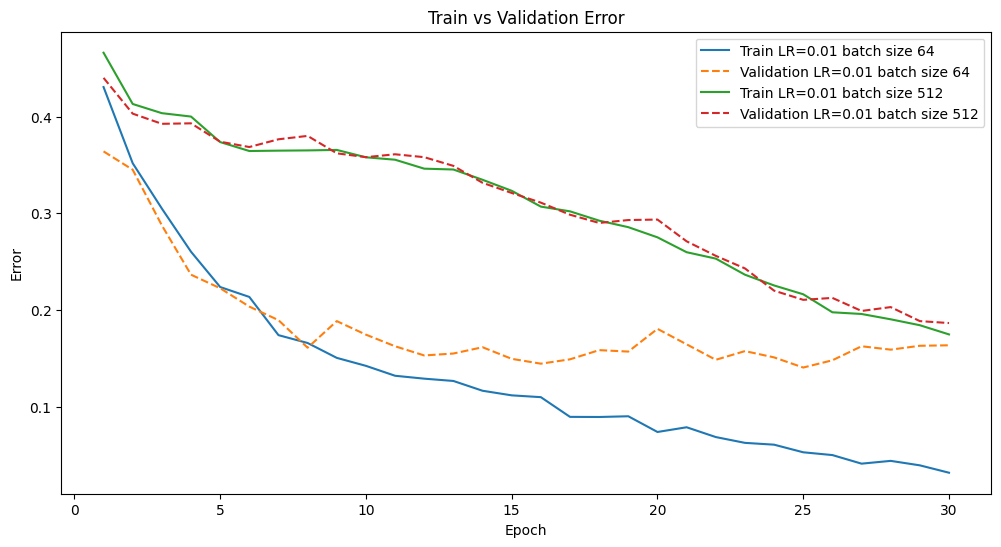

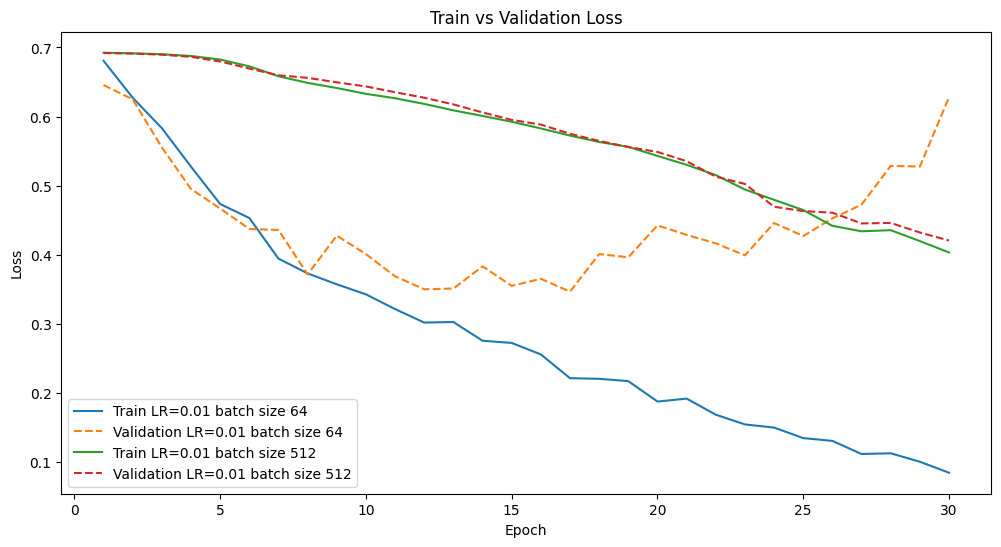

In [87]:
plot_multiple_training_curves(['model_large_bs64_lr0.01_epoch29', 'model_large_bs512_lr0.01_epoch29'],  ["LR=0.01 batch size 64","LR=0.01 batch size 512"])

### Part (iv) [0.5pt EXPLORATORY] - decreasing the batch size

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=16`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *decreasing* the batch size.

> The batch size of 16 causes the model to plateau rapidly, indicating possible divergence or getting stuck in poor local minima. It appears that this model may be diverging or getting stuck very early in training. Both training and validation errors plateau quickly. This can be caused by the noisy gradient updates that come with very small batch sizes, which may cause the model to jump around the optimization landscape. Too large of a batch size can be slow and less generalizing, but too small can lead to instability.

In [88]:
large_net = LargeNet()
train_net(large_net, batch_size=16, learning_rate=0.01, num_epochs=30)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.34375, Train loss: 0.6175165125727653 |Validation err: 0.2625, Validation loss: 0.540454069852829
Model Path
model_large_bs16_lr0.01_epoch0
Epoch 2: Train err: 0.22325, Train loss: 0.4730004854500294 |Validation err: 0.2035, Validation loss: 0.43918069565296175
Model Path
model_large_bs16_lr0.01_epoch1
Epoch 3: Train err: 0.25525, Train loss: nan |Validation err: 0.4905, Validation loss: nan
Model Path
model_large_bs16_lr0.01_epoch2
Epoch 4: Train err: 0.502375, Train loss: nan |Validation err: 0.4905, Validation loss: nan
Model Path
model_large_bs16_lr0.01_epoch3
Epoch 5: Train err: 0.502375, Train loss: nan |Validation err: 0.4905, Validation loss: nan
Model Path
model_large_bs16_lr0.01_epoch4
Epoch 6: Train err: 0.502375, Train loss: nan |Validation err: 0.4905, Validation loss: nan
Model Path
model_large_bs16_lr0.01_epoch5
Epoch 7: Train err: 0.502375, Train loss: nan |Validation err: 

Train Error for LR=0.01 batch size 16: [0.34375  0.22325  0.25525  0.502375 0.502375 0.502375 0.502375 0.502375
 0.502375 0.502375 0.502375 0.502375 0.502375 0.502375 0.502375 0.502375
 0.502375 0.502375 0.502375 0.502375 0.502375 0.502375 0.502375 0.502375
 0.502375 0.502375 0.502375 0.502375 0.502375 0.502375]
Validation Error for LR=0.01 batch size 16: [0.2625 0.2035 0.4905 0.4905 0.4905 0.4905 0.4905 0.4905 0.4905 0.4905
 0.4905 0.4905 0.4905 0.4905 0.4905 0.4905 0.4905 0.4905 0.4905 0.4905
 0.4905 0.4905 0.4905 0.4905 0.4905 0.4905 0.4905 0.4905 0.4905 0.4905]
Train Error for LR=0.01 batch size 64: [0.4305   0.35175  0.304875 0.26025  0.22375  0.2135   0.174    0.165875
 0.1505   0.14225  0.132    0.129    0.126625 0.1165   0.11175  0.109875
 0.0895   0.089375 0.090125 0.073875 0.07875  0.068625 0.062625 0.06075
 0.052875 0.05     0.041125 0.044    0.039375 0.03175 ]
Validation Error for LR=0.01 batch size 64: [0.364  0.345  0.2875 0.2365 0.2225 0.2035 0.1895 0.161  0.1885 0.1745


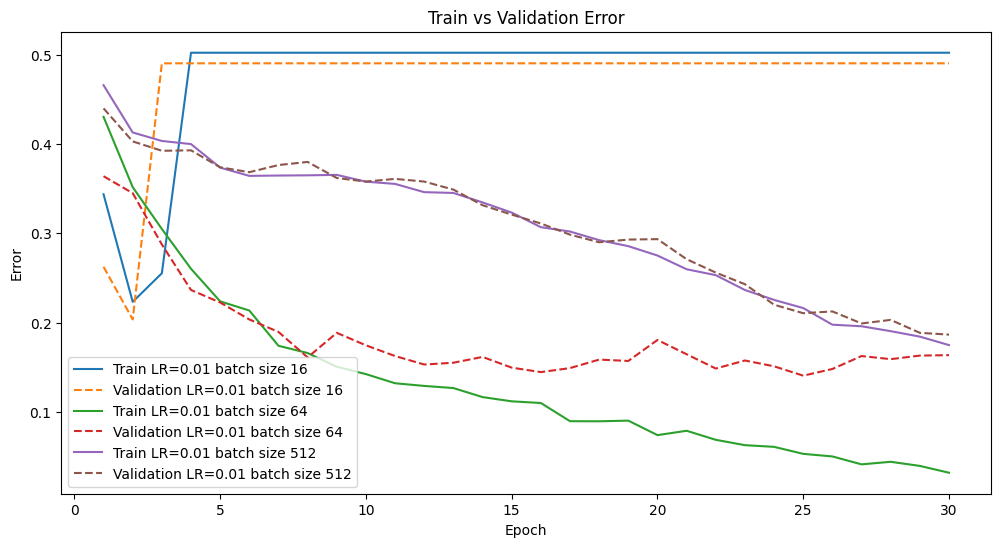

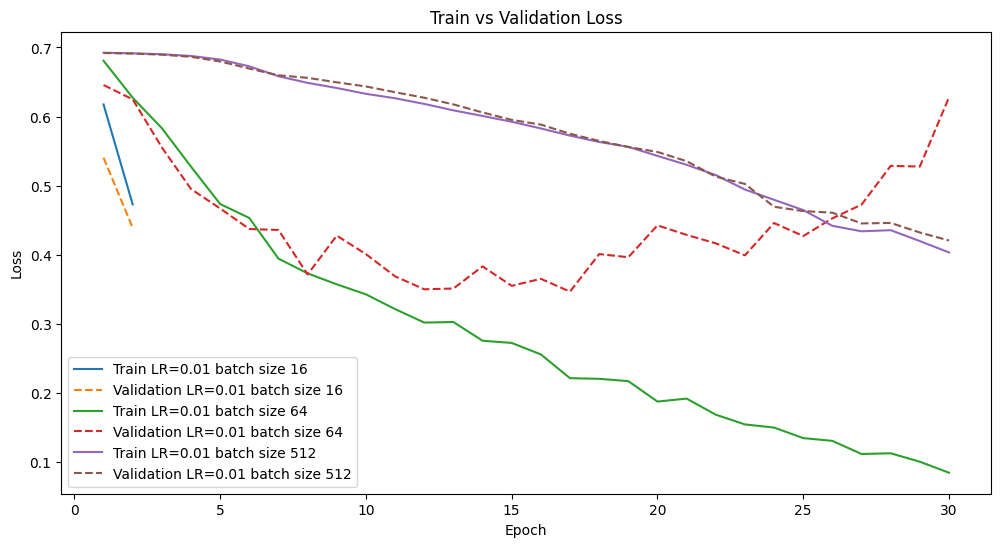

In [89]:
plot_multiple_training_curves(['model_large_bs16_lr0.01_epoch29', 'model_large_bs64_lr0.01_epoch29', 'model_large_bs512_lr0.01_epoch29'],  ["LR=0.01 batch size 16", "LR=0.01 batch size 64","LR=0.01 batch size 512"])

## Part 4. Hyperparameter Search

### Part (i) [1pt EXPLORATORY]

Based on the plots from above, choose another set of values for the hyperparameters (network, batch_size, learning_rate)
that you think would help you improve the validation accuracy. Justify your choice.


> A **learning rate of 0.001** seemed the most effective given that 0.01 and 0.1 were both overfitting.

>  Based on the data, a **batch size of 64 seemed to be the most effective**. The model with a batch size of 16 diverged, while the one with 512 was slower to converge. The batch size of 64 had a good balance of stability and speed of convergence.

> Small net is better than large net as it shows.

In [31]:
def extract_data_from_dataloader(dataloader):
    data_list = []
    label_list = []

    for data, labels in dataloader:
        data_list.append(data)
        label_list.append(labels)

    X = torch.cat(data_list, 0)
    y = torch.cat(label_list, 0)
    return X, y

target_classes = ["car", "truck"]

train_loader, val_loader, test_loader, classes = get_data_loader(target_classes, batch_size=64)  # assuming get_data_loader is defined

X_train, y_train = extract_data_from_dataloader(train_loader)
X_val, y_val = extract_data_from_dataloader(val_loader)


Files already downloaded and verified
Files already downloaded and verified


In [42]:
train_net(small_net, batch_size=64, learning_rate=0.001, num_epochs=30)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.20275, Train loss: 0.4515094699859619 |Validation err: 0.227, Validation loss: 0.4686920093372464
Model Path
model_small_bs64_lr0.001_epoch0
Epoch 2: Train err: 0.204875, Train loss: 0.4492790911197662 |Validation err: 0.2235, Validation loss: 0.46778780315071344
Model Path
model_small_bs64_lr0.001_epoch1
Epoch 3: Train err: 0.203125, Train loss: 0.4471832251548767 |Validation err: 0.223, Validation loss: 0.46473778411746025
Model Path
model_small_bs64_lr0.001_epoch2
Epoch 4: Train err: 0.201875, Train loss: 0.4456551539897919 |Validation err: 0.216, Validation loss: 0.4590149810537696
Model Path
model_small_bs64_lr0.001_epoch3
Epoch 5: Train err: 0.201, Train loss: 0.443510418176651 |Validation err: 0.2225, Validation loss: 0.45923823583871126
Model Path
model_small_bs64_lr0.001_epoch4
Epoch 6: Train err: 0.20225, Train loss: 0.44174096775054933 |Validation err: 0.218, Validation loss: 0.

Train Error for LR=0.001 batch size 64 Small: [0.16025  0.15875  0.159125 0.15375  0.153875 0.151    0.146    0.144625
 0.141125 0.140625 0.138875 0.139    0.1385   0.134125 0.137875 0.13275
 0.129    0.13375  0.1275   0.124125 0.124375 0.12175  0.12025  0.12
 0.1175   0.118375 0.118875 0.111    0.11525  0.11475 ]
Validation Error for LR=0.001 batch size 64 Small: [0.163  0.173  0.167  0.1595 0.1545 0.15   0.1525 0.1605 0.1665 0.1555
 0.154  0.1445 0.1555 0.1735 0.152  0.1355 0.1445 0.1505 0.1395 0.1565
 0.137  0.1405 0.156  0.166  0.1325 0.166  0.162  0.138  0.1265 0.15  ]
Train Error for LR=0.001 batch size 64 Large: [0.20275  0.204875 0.203125 0.201875 0.201    0.20225  0.197125 0.196625
 0.19425  0.1935   0.19375  0.192125 0.1915   0.190625 0.192125 0.190125
 0.18875  0.1875   0.18575  0.18675  0.184875 0.18425  0.185125 0.18225
 0.183375 0.1825   0.1795   0.17975  0.178875 0.176375]
Validation Error for LR=0.001 batch size 64 Large: [0.227  0.2235 0.223  0.216  0.2225 0.218  0.215

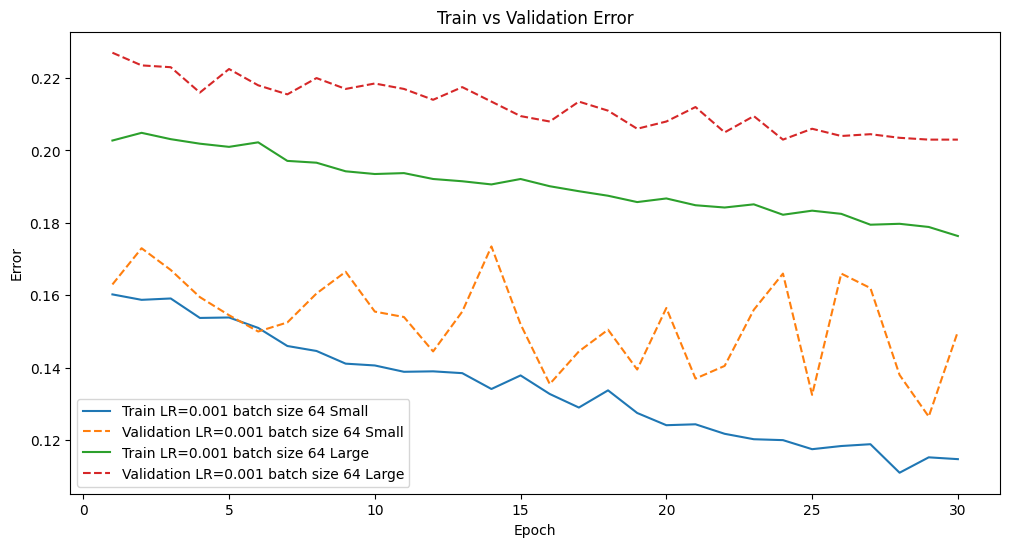

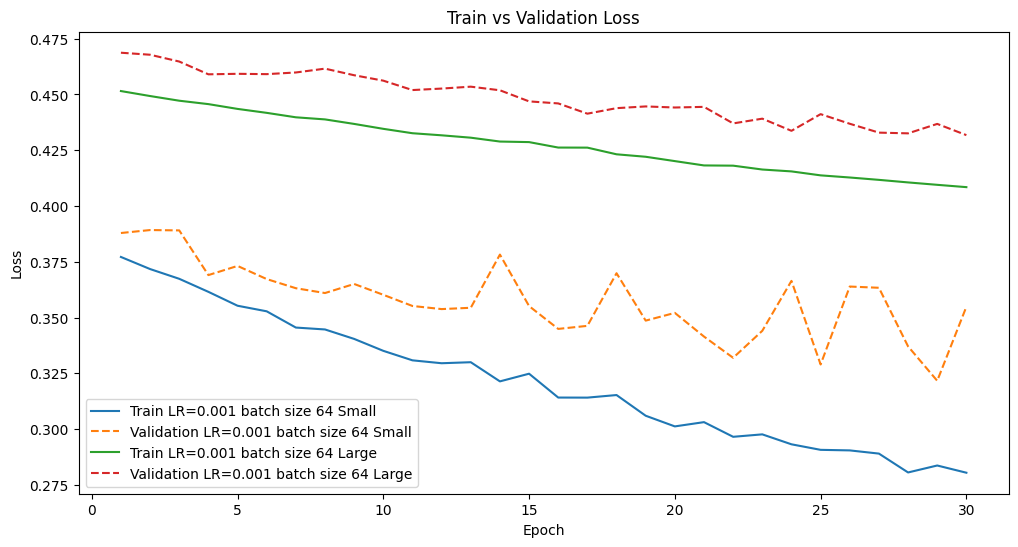

In [43]:
plot_multiple_training_curves(['model_large_bs64_lr0.001_epoch29', 'model_small_bs64_lr0.001_epoch29'],  ["LR=0.001 batch size 64 Small", "LR=0.001 batch size 64 Large"])